In [37]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices, ShapleyKrigingIndices
from shapley.tests import Ishigami, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True
ylim = [0., 1.]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model

In [2]:
dim = 2
beta = None
model = AdditiveGaussian(dim=dim, beta=beta)
theta = [0.3]
model.copula_parameters = theta

In [3]:
if None:
    dim = 3
    beta = None
    model = AdditiveGaussian(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.9]
    model.copula_parameters = theta

## Sobol indices with a classical Monte-Carlo sampling

In [23]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_perms = None
Nv = 500
No = 10
Ni = 100

# Evaluate the model
shapley = ShapleyIndices(model.input_distribution)
shapley.build_mc_sample(model=model, n_perms=n_perms, Nv=Nv, No=No, Ni=Ni)

In [24]:
n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)

In [25]:
shapley_results.true_first_indices = model.first_order_sobol_indices
shapley_results.true_total_indices = model.total_sobol_indices
shapley_results.true_shapley_indices = model.shapley_indices

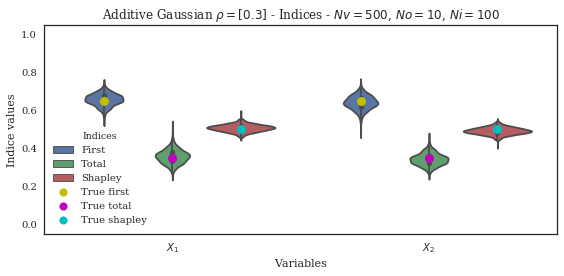

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapley_additive_gaussian.pdf')

In [27]:
def get_confidence_interval(results, quantiles=[2.5, 97.5]):
    """
    """
    interval = 2*results[:, 0].T - np.percentile(results, quantiles[::-1], axis=1)
    return interval.T

In [28]:
get_confidence_interval(shapley_results.full_shapley_indices)

array([[ 0.47084532,  0.54491642],
       [ 0.45508358,  0.52915468]])

In [29]:
get_confidence_interval(shapley_results.full_first_indices)

array([[ 0.59756218,  0.71786739],
       [ 0.57213414,  0.71325755]])

In [30]:
get_confidence_interval(shapley_results.full_total_indices)

array([[ 0.28674245,  0.42786586],
       [ 0.28213261,  0.40243782]])

## Kriging Model

In [48]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 100
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sampling = 'monte-carlo'
shapley_kriging = ShapleyKrigingIndices(model.input_distribution)
meta_model = shapley_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library,
                                             sampling=sampling)

In [49]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
Nv = 500
No = 10
Ni = 100
n_realization = 500

# Evaluate the kriging model
shapley_kriging.build_mc_sample(model=meta_model, n_perms=None, Nv=Nv, No=No, Ni=Ni, n_realization=n_realization)

Wall time: 5.83 s


In [50]:
n_boot = 1000
shapley_kriging_results = shapley_kriging.compute_indices(n_boot=n_boot)

In [51]:
shapley_kriging_results.true_first_indices = model.first_order_sobol_indices
shapley_kriging_results.true_total_indices = model.total_sobol_indices
shapley_kriging_results.true_shapley_indices = model.shapley_indices

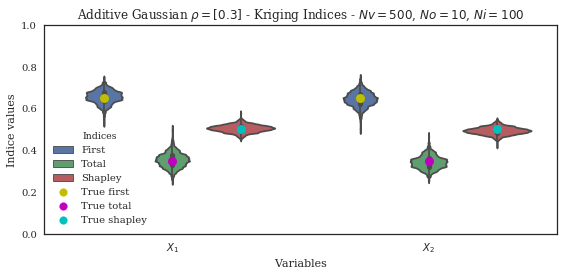

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_kriging_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')

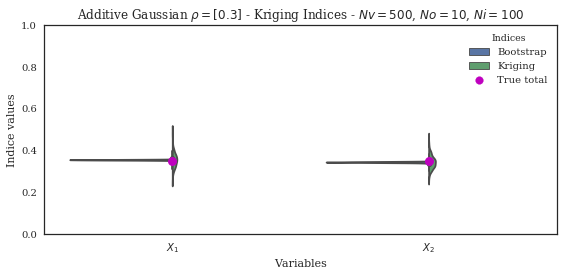

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_kriging_results, indice='total', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, Nv, No, Ni))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/shapleyGP_additive_gaussian.pdf')